In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import wmfdata as wmf

In [68]:
mpl.style.use({
  "font.size": 20,
  "figure.figsize": (20, 7.6),
  "axes.grid": True,
  "axes.autolimit_mode": "data",
  "axes.xmargin": 0,
  "axes.ymargin": 0,
  "lines.linewidth": 2
})

In [5]:
CHART_START = "2015-01"
MWH_SNAPSHOT = "2020-07" # The end of this month will also be the end of the charts

time_range = pd.period_range(CHART_START, pd.Period(MWH_SNAPSHOT), freq="W-SUN")
time_end = time_range[-1].to_timestamp(how="end")

# If the last week goes past the end of mediawiki_history, remove it
if time_end > pd.Timestamp(MWH_SNAPSHOT):
  time_range = time_range[:-1]
  time_start = time_range[0].to_timestamp(how="start")
  time_end = (time_range[-1] + 1).to_timestamp(how="start")
    
query_params = {
  "mwh_snapshot": MWH_SNAPSHOT,
  "time_start": time_start,
  "time_end": time_end
}

In [8]:
query = """
  SELECT
    wiki_db AS wiki,
    DATE_FORMAT(event_timestamp, "yyyy-MM-dd") AS date,
    COUNT(*) AS translations_published
  FROM wmf.mediawiki_history
  WHERE
    snapshot = "{mwh_snapshot}" AND
    event_timestamp BETWEEN "{time_start}" AND "{time_end}" AND
    event_entity = "revision" AND
    event_type = "create" AND
    array_contains(revision_tags, "contenttranslation")
  GROUP BY
    wiki_db,
    DATE_FORMAT(event_timestamp, "yyyy-MM-dd")
""".format(**query_params)

translations = (
  wmf.spark.run(query, session_type="large")
  .assign(date=lambda df: pd.to_datetime(df["date"]))
  .assign(week=lambda df: df["date"].dt.to_period("W-SUN").dt.to_timestamp())
)

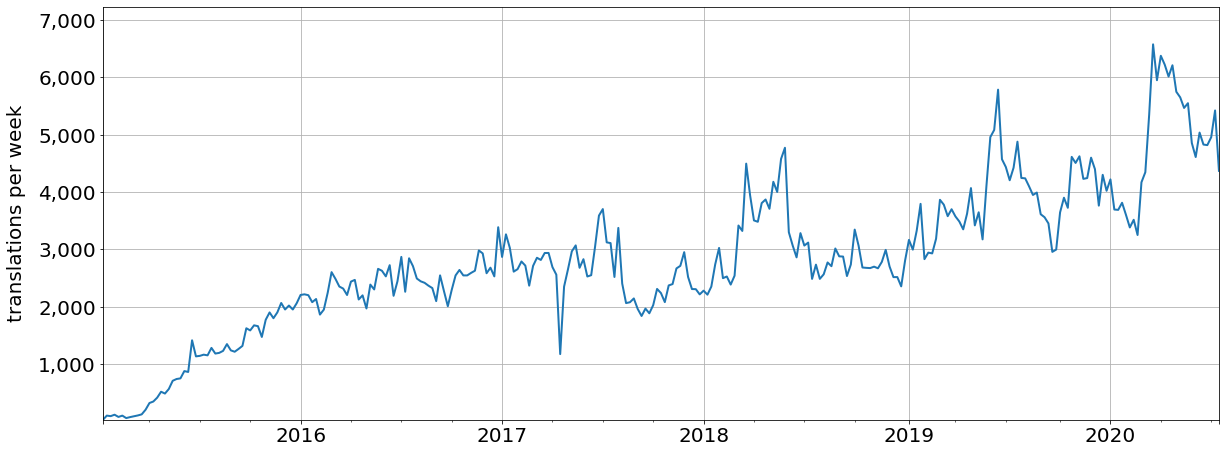

In [67]:
weekly_translations = translations.groupby("week")["translations_published"].sum()

ax = weekly_translations.plot()
ylim = plt.ylim()
plt.ylim((ylim[0], ylim[1] * 1.1))
ax.yaxis.set_major_formatter(wmf.charting.comma_fmt)
plt.ylabel("translations per week", labelpad=12)
plt.xlabel("");

In [40]:
wp_langs = wmf.spark.run("""
SELECT
  database_code AS wiki,
  language_name
FROM canonical_data.wikis
WHERE database_group = "wikipedia"
""")

In [ ]:
wp_langs = (
  wp_langs.set_index("wiki")
)

In [58]:
translations_by_wiki = (
  translations
  .groupby("wiki")["translations_published"].sum()
  .sort_values(ascending=False)
  .head(10)
  .to_frame()
  .join(wp_langs, on="wiki")
  .reset_index(drop=True)
  .set_index("language_name")
  # For some reason, the horizontal bar chart flips the order of rows
  .sort_values("translations_published")
)

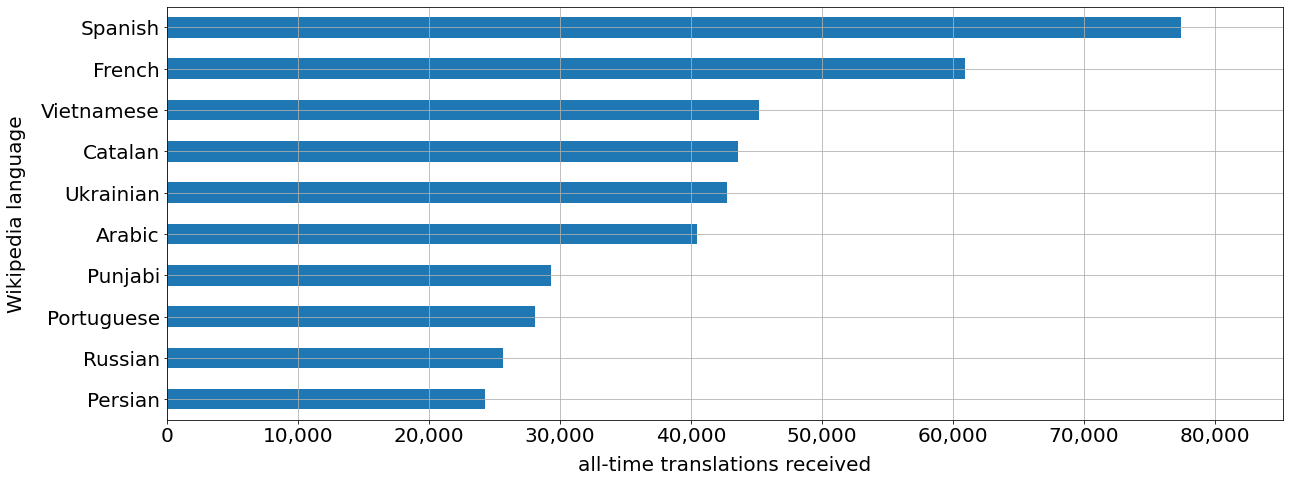

In [72]:
ax = translations_by_wiki.plot(kind="barh", legend=None)
ax.xaxis.set_major_formatter(wmf.charting.comma_fmt)
plt.ylabel("Wikipedia language", labelpad=15)
plt.xlabel("all-time translations received", labelpad=10)
xlim = plt.xlim()
plt.xlim((xlim[0], xlim[1] * 1.1));